In [1]:
import torch
from torch import nn

class NNUE(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(248, 24),
            nn.ReLU(),
            nn.Linear(24, 12),
            nn.ReLU(),
            nn.Linear(12, 1),
            nn.Hardtanh(0.0, 100.0),
        )
    
    def forward(self, x):
        return self.net(x)

torch.manual_seed(42)

In [2]:
def list_to_tensor(arr: list[int]) -> torch.Tensor:
    res = torch.zeros((248), dtype=torch.float32)

    cnt = [0] * 31
    for i in range(4):
        cnt[arr[i]] += 1
        if cnt[arr[i]] > 1:
            res[8 * arr[i] + cnt[arr[i]] - 2] = 0.0
        res[8 * arr[i] + cnt[arr[i]] - 1] = 1.0

    cnt = [0] * 31
    for i in range(4, 8):
        cnt[arr[i]] += 1
        if cnt[arr[i]] > 1:
            res[8 * arr[i] + cnt[arr[i]] + 2] = 0.0
        res[8 * arr[i] + cnt[arr[i]] + 3] = 1.0

    return res

In [3]:
f = open("models/model39.pt", "rb")
nnue = torch.jit.load(f)
print(nnue(list_to_tensor([0, 0, 0, 0, 0, 0, 0, 0])))
f.close()

tensor([48.4749], grad_fn=<HardtanhBackward0>)


[(24, 24, 24, 2, 16, 23, 7, 10), (19, 5, 8, 21, 26, 26, 26, 15), (0, 27, 27, 28, 4, 4, 18, 11), (9, 11, 28, 25, 25, 25, 25, 13), (5, 11, 29, 29, 3, 3, 14, 19)]


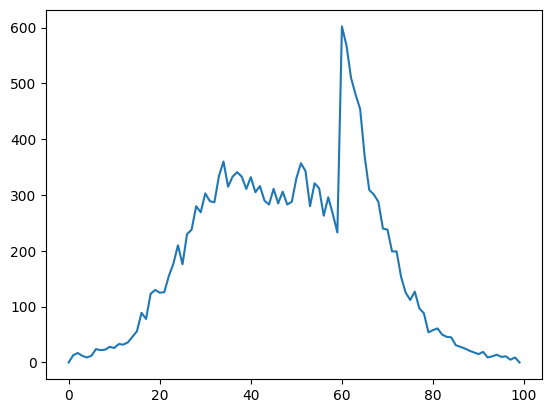

In [4]:
import matplotlib.pyplot as plt
import pickle

f = open("add_data.pickle", "rb")
data, label = pickle.load(f)
print(data[:5])
f.close()
freq = [0] * 100
for i in label:
    freq[int(i)] += 1
plt.plot(range(100), freq)

In [5]:
from torch.optim import Adam
from torch.utils.data import TensorDataset, DataLoader

TRAIN_SIZE = 6144
TEST_SIZE = 2048
BATCH_SIZE = 512

In [6]:
import random

def create_loader() -> tuple[DataLoader, DataLoader]:
    x_train, y_train = [], []
    for _ in range(TRAIN_SIZE):
        i = random.randint(0, 17999)
        x_train.append(list_to_tensor(data[i]))
        y_train.append(torch.tensor([label[i]]))
    x_train = torch.stack(x_train).type(torch.float32)
    y_train = torch.stack(y_train).type(torch.float32)

    x_test, y_test = [], []
    for _ in range(TEST_SIZE):
        i = random.randint(0, 17999)
        x_test.append(list_to_tensor(data[i]))
        y_test.append(torch.tensor([label[i]]))
    x_test = torch.stack(x_test).type(torch.float32)
    y_test = torch.stack(y_test).type(torch.float32)

    train_set = TensorDataset(x_train, y_train)
    test_set = TensorDataset(x_test, y_test)
    train_loader = DataLoader(train_set, BATCH_SIZE)
    test_loader = DataLoader(test_set, BATCH_SIZE)

    return (train_loader, test_loader)

In [7]:
crit = nn.MSELoss()
optim = Adam(nnue.parameters(), 1e-3)

def early_train(epoch: int, start: int) -> float:
    history = []
    for i in range(epoch):
        train_loader, test_loader = create_loader()

        nnue.train()
        for batch_x, batch_y in train_loader:
            optim.zero_grad()
            outs = nnue(batch_x)
            loss = crit(outs, batch_y)
            loss.backward()
            optim.step()

        nnue.eval()
        loss = 0.0
        with torch.no_grad():
            for batch_x, batch_y in test_loader:
                outs = nnue(batch_x)
                loss += crit(outs, batch_y)
        history.append(loss)
        if i % 5 == 4:
            print(i + 1, end=' ')

    plt.plot(range(start, epoch + start), history)
    return loss  # type: ignore

5 10 15 20 25 30 35 40 45 50 55 60 65 70 75 80 85 90 95 100 
5 10 15 20 25 30 35 40 45 50 55 60 65 70 75 80 85 90 95 100 
5 10 15 20 25 30 35 40 45 50 55 60 65 70 75 80 85 90 95 100 
5 10 15 20 25 30 35 40 45 50 55 60 65 70 75 80 85 90 95 100 
5 10 15 20 25 30 35 40 45 50 55 60 65 70 75 80 85 90 95 100 
5 10 15 20 25 30 35 40 45 50 55 60 65 70 75 80 85 90 95 100 
5 10 15 20 25 30 35 40 45 50 55 60 65 70 75 80 85 90 95 100 
5 10 15 20 25 30 35 40 45 50 55 60 65 70 75 80 85 90 95 100 
5 10 15 20 25 30 35 40 45 50 55 60 65 70 75 80 85 90 95 100 
5 10 15 20 25 30 35 40 45 50 55 60 65 70 75 80 85 90 95 100 
5 10 15 20 25 30 35 40 45 50 55 60 65 70 75 80 85 90 95 100 
5 10 15 20 25 30 35 40 45 50 55 60 65 70 75 80 85 90 95 100 
5 10 15 20 25 30 35 40 45 50 55 60 65 70 75 80 85 90 95 100 
5 10 15 20 25 30 35 40 45 50 55 60 65 70 75 80 85 90 95 100 
5 10 15 20 25 30 35 40 45 50 55 60 65 70 75 80 85 90 95 100 
5 10 15 20 25 30 35 40 45 50 55 60 65 70 75 80 85 90 95 100 
5 10 15 20 25 30 35 40 4

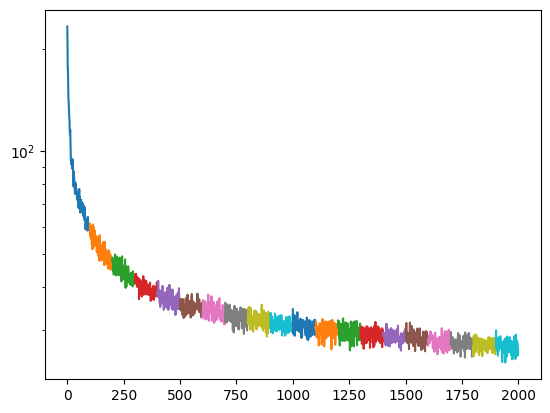

In [8]:
plt.yscale("log")
for i in range(20):
    early_train(100, 100 * i)
    sm = torch.jit.script(nnue)
    sm.save(f"C:/Users/ljw10/Desktop/LeeJunWoo/gshs/research/grade1/codes_final/models/model{i + 40}.pt")
    print()

In [9]:
nnue(list_to_tensor([30, 30, 30, 20, 30, 0, 0, 0]))

tensor([74.3378], grad_fn=<DifferentiableGraphBackward>)